In [6]:
import yfinance as yf

from datetime import date, timedelta

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense

import matplotlib.pyplot as plt 
import seaborn as sns

In [38]:
path = "Data\\"

stocks_list = ["AAPL", "TSLA", "MSFT", "GOOGL", "NFLX", "META", "QCOM"]

for stock in stocks_list:
    data = yf.download(stock, start="2010-04-20", end="2023-04-26")
    data.to_csv(path+stock+".csv")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [2]:
import os

import numpy as np
import pandas as pd

class Dataset(object):
    def __init__(self,path, file, input_steps=30, output_steps=7, train_ratio=0.8):
        self.input_steps=input_steps
        self.output_steps=output_steps
        self.file_path = path+file+".csv"
        self.train_ratio = train_ratio
        self.X, self.Y = self._prepare_data()
    
    def _prepare_data(self):
        X = []
        Y = []
        data = pd.read_csv(self.file_path)
        data = data.drop(columns="Date")
        data["Volume"] = data["Volume"]/1000000
        data = data.to_numpy()
        for i in range(data.shape[0]-self.input_steps-self.output_steps):
            X.append(data[i:i+self.input_steps])
            Y.append(data[i+self.input_steps:i+self.input_steps+self.output_steps, 3])
        X = np.array(X)
        Y = np.array(Y)
        
        return X, Y
    
data = Dataset(path="Data\\", file="AAPL", input_steps=30 , output_steps=7)

In [3]:
def RNN_model():
    model = Sequential()
    model.add(LSTM(128, input_shape=(30, 6), return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(64))
    model.add(Dense(32))
    model.add(Dense(7, activation='linear'))

    return model

model = RNN_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           69120     
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                                 
Total params: 135,367
Trainable params: 135,367
Non-trai

In [41]:

# # Evaluate the model
# test_predictions = model.predict(test_data_scaled)
# test_loss = np.mean(np.square(test_predictions - test_data['Close']))

def compile_and_fit(model,data , patience=2, MAX_EPOCHS=300):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(data.X, data.Y, epochs=MAX_EPOCHS, shuffle=True,
                      callbacks=[early_stopping])
  return history

hist = compile_and_fit(model=model, data=data, patience=3, MAX_EPOCHS=300)

Epoch 1/300
678/678 [==============================] - 89s 126ms/step - loss: 3210.8621 - mean_absolute_error: 21.9407
Epoch 2/300
678/678 [==============================] - 98s 144ms/step - loss: 231.4074 - mean_absolute_error: 7.4535
Epoch 3/300
678/678 [==============================] - 108s 159ms/step - loss: 243.7050 - mean_absolute_error: 7.4169
Epoch 4/300
678/678 [==============================] - 108s 160ms/step - loss: 400.8723 - mean_absolute_error: 9.2059
Epoch 5/300
678/678 [==============================] - 114s 169ms/step - loss: 311.0102 - mean_absolute_error: 8.5595


In [54]:
data.Y.shape

(3240, 7)

In [59]:
def train_stock_weights(stock):
    data = Dataset(path="Data\\", file=stock)
    model = RNN_model()
    hist = compile_and_fit(model,data, patience=3, MAX_EPOCHS=50)
    model.save_weights("Weights\\"+stock+"_weights.h5")
    

In [60]:

stocks_list = ["AAPL", "TSLA", "MSFT", "GOOGL", "NFLX", "META", "QCOM"]

for stock in stocks_list:
    train_stock_weights(stock=stock)

Epoch 1/50
102/102 [==============================] - 7s 35ms/step - loss: 3877.0066 - mean_absolute_error: 44.0044
Epoch 2/50
102/102 [==============================] - 4s 37ms/step - loss: 442.0998 - mean_absolute_error: 10.3890
Epoch 3/50
102/102 [==============================] - 4s 36ms/step - loss: 37.9781 - mean_absolute_error: 3.8136
Epoch 4/50
102/102 [==============================] - 4s 39ms/step - loss: 31.9224 - mean_absolute_error: 3.3666
Epoch 5/50
102/102 [==============================] - 4s 39ms/step - loss: 27.4166 - mean_absolute_error: 3.2130
Epoch 6/50
102/102 [==============================] - 4s 42ms/step - loss: 25.1863 - mean_absolute_error: 3.1060
Epoch 7/50
102/102 [==============================] - 5s 46ms/step - loss: 21.2125 - mean_absolute_error: 2.8618
Epoch 8/50
102/102 [==============================] - 4s 43ms/step - loss: 21.5176 - mean_absolute_error: 3.0117
Epoch 9/50
102/102 [==============================] - 4s 43ms/step - loss: 17.4113 - mean_a

In [28]:
def plot_prediction(stock):
    model = RNN_model()
    model.load_weights("Weights\\GOOGL_weights.h5")

    
    current_date = date.today().isoformat()   
    days_before = (date.today()-timedelta(days=45)).isoformat() 
    data = yf.download(stock, start=days_before, end=current_date)
    data = data.tail(30)
    data["Volume"]/=1000000
    
    label = data.index
    data = data.to_numpy()
    pred = model.predict(np.reshape(data, (1,30,6)))[0]
  
    last = label[-1]
    label_pred=[]
    for i in range(0,8):
        label_pred.append(last + timedelta(days=i))
        
    
    fig = plt.figure(figsize=(16,6))
    plt.plot(label,data[:,3])
    
    plt.plot(label_pred,np.append(np.array([data[-1,3]]),pred))
    return fig
    

    

[*********************100%***********************]  1 of 1 completed


C:\Users\bhanu\AppData\Local\Temp\ipykernel_33316\2768961330.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Volume"]/=1000000


1/1 [==============================] - 1s 586ms/step


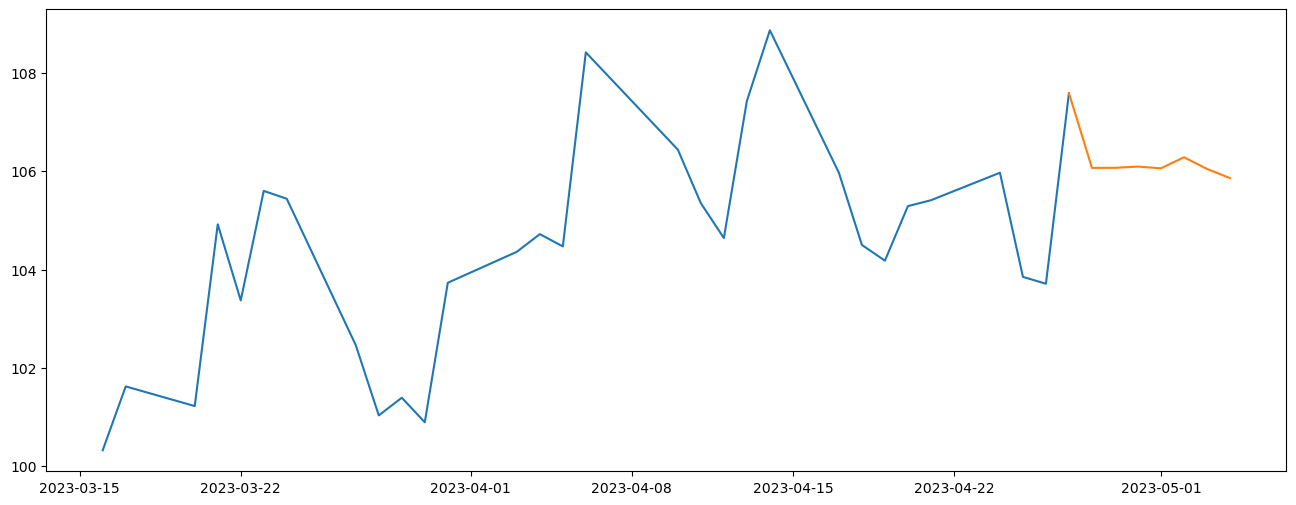

In [29]:
data, pred = plot_prediction("GOOGL")